In [1]:
import os
import cv2
from tqdm import tqdm
import albumentations as A
from PIL import Image
import numpy as np
from pathlib import Path

input_dir = Path("/kaggle/input/fishes/Fishes")
output_dir = Path("/kaggle/working/augmented")
output_dir.mkdir(exist_ok=True)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.3),
    A.RandomCrop(width=200, height=200, p=0.5),
    A.HueSaturationValue(p=0.3),
    A.GaussNoise(p=0.3),
])

for cls in os.listdir(input_dir):
    cls_path = input_dir / cls
    if not cls_path.is_dir():
        continue
    
    (output_dir / cls).mkdir(exist_ok=True)

    images = list(cls_path.glob("*.*"))
    
    for img_path in tqdm(images, desc=f"Augmenting {cls}"):
        img = cv2.imread(str(img_path))[:,:,::-1]
        
        # 5 augmentations per image
        for i in range(10):
            aug = transform(image=img)['image']
            aug = cv2.cvtColor(aug, cv2.COLOR_RGB2BGR)

            save_name = f"{img_path.stem}_aug_{i}.jpg"
            cv2.imwrite(str(output_dir/cls/save_name), aug)

print("DONE!")

Augmenting Croaker(Poya): 100%|██████████| 11/11 [00:24<00:00,  2.20s/it]

DONE!


Show augmentation image

In [2]:
aug_count = sum(len(files) for _,_,files in os.walk(output_dir))
print("TOTAL AUGMENTED IMAGES =", aug_count)

TOTAL AUGMENTED IMAGES = 5830


Resize

In [3]:
import os
from pathlib import Path
from PIL import Image
from tqdm import tqdm

SRC = Path("/kaggle/working/augmented")
DST = Path("/kaggle/working/Fishes_resized")
DST.mkdir(parents=True, exist_ok=True)

TARGET_SIZE = (256, 256)   # যেকোনো সাইজ রাখতে পারবেন

for cls in sorted([d.name for d in SRC.iterdir() if d.is_dir()]):
    (DST/cls).mkdir(exist_ok=True)
    for img_path in tqdm(list((SRC/cls).glob("*.*")), desc=cls):
        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize(TARGET_SIZE, Image.BILINEAR)
            img.save(DST/cls/img_path.name)
        except:
            pass

print("DONE — All images resized!")

shrimp: 100%|██████████| 260/260 [00:16<00:00, 15.38it/s]

DONE — All images resized!


Import and config

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

test_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [6]:
data_root = "/kaggle/working/Fishes_resized"

full_dataset = datasets.ImageFolder(data_root, transform=train_tf)
class_names = full_dataset.classes
num_classes = len(class_names)

len(full_dataset), num_classes

(5830, 21)

In [7]:
val_size = int(0.2 * len(full_dataset))
train_size = len(full_dataset) - val_size

train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

# validationের tf ঠিক করা
val_ds.dataset.transform = test_tf

In [8]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

In [9]:
model = models.googlenet(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 201MB/s]


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [11]:
num_epochs = 50
best_val_loss = np.inf
patience = 5
wait = 0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):

    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = torch.max(outputs, 1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    model.eval()
    v_loss = 0
    v_correct = 0
    v_total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            v_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            v_correct += (pred == labels).sum().item()
            v_total += labels.size(0)

    val_loss = v_loss / len(val_loader)
    val_acc = v_correct / v_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f} "
          f"Train Acc: {train_acc:.4f} Val Acc: {val_acc:.4f}")



Epoch [1/50] Train Loss: 2.0540 Val Loss: 1.3939 Train Acc: 0.4631 Val Acc: 0.6029
Epoch [2/50] Train Loss: 1.2472 Val Loss: 1.1567 Train Acc: 0.6269 Val Acc: 0.6175
Epoch [3/50] Train Loss: 1.0245 Val Loss: 1.1219 Train Acc: 0.6833 Val Acc: 0.6364
Epoch [4/50] Train Loss: 0.8559 Val Loss: 1.0674 Train Acc: 0.7275 Val Acc: 0.6552
Epoch [5/50] Train Loss: 0.6852 Val Loss: 1.1178 Train Acc: 0.7854 Val Acc: 0.6415
Epoch [6/50] Train Loss: 0.5326 Val Loss: 1.1007 Train Acc: 0.8435 Val Acc: 0.6509
Epoch [7/50] Train Loss: 0.4110 Val Loss: 1.1812 Train Acc: 0.8823 Val Acc: 0.6535
Epoch [8/50] Train Loss: 0.2944 Val Loss: 1.2145 Train Acc: 0.9207 Val Acc: 0.6621
Epoch [9/50] Train Loss: 0.2098 Val Loss: 1.2675 Train Acc: 0.9520 Val Acc: 0.6527
Epoch [10/50] Train Loss: 0.1372 Val Loss: 1.3274 Train Acc: 0.9696 Val Acc: 0.6518
Epoch [11/50] Train Loss: 0.0959 Val Loss: 1.3267 Train Acc: 0.9822 Val Acc: 0.6467
Epoch [12/50] Train Loss: 0.0654 Val Loss: 1.4254 Train Acc: 0.9880 Val Acc: 0.6407
E

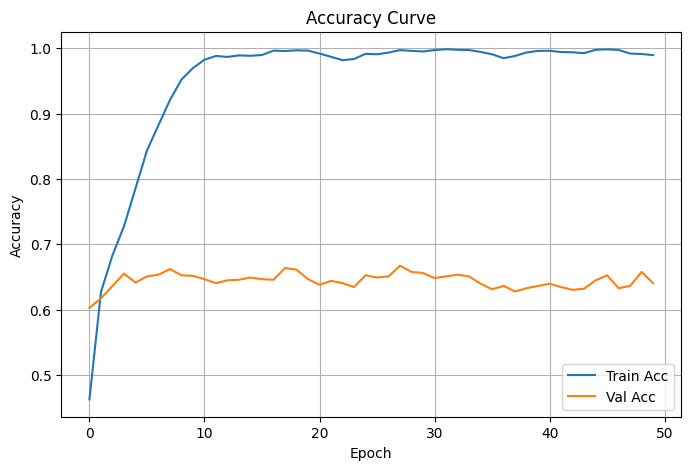

In [12]:
plt.figure(figsize=(8,5))
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

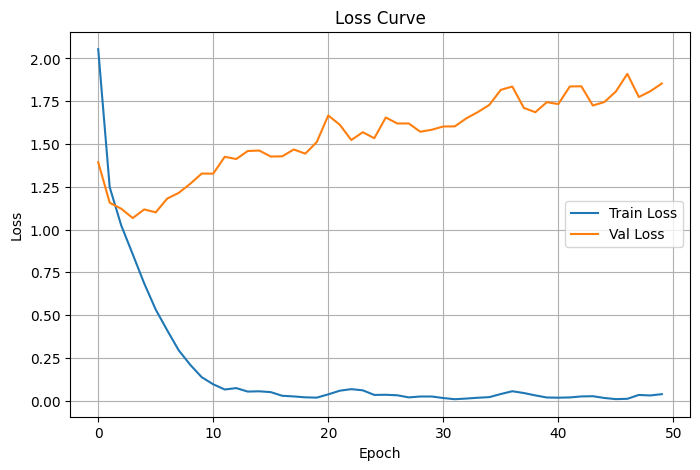

In [13]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()